<a href="https://colab.research.google.com/github/ranjanchoubey/ml2/blob/main/assignment-1/Q3-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<pre>
Name : Ranjan Kumar Choubey
Class : M.Tech CS 2023-25
Roll No : CS2316
</pre>

![heading](https://raw.githubusercontent.com/ranjanchoubey/ml2/main/assignment-1/assets/heading.png)

![q3.1.png](https://raw.githubusercontent.com/ranjanchoubey/ml2/main/assignment-1/assets/q3.1.png)

**Solution :**

In [17]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

---

### **Step1 :** Loading and Preprocessing the MNIST Data
- We load the MNIST dataset, which consists of 28x28 grayscale images of handwritten digits.

- Each image is flattened into a vector of size 784 (since 28 * 28 = 784) and normalized to have values in the range [0, 1].


In [18]:
# Load and preprocess MNIST data
(x_train, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [27]:
x_train.shape

(60000, 784)

In [28]:
x_test.shape

(10000, 784)

---

### **Step2 :** Building the Variational Autoencoder (VAE)
The VAE consists of an encoder, which compresses the input data into a latent space, and a decoder, which reconstructs the data from this latent space.

#### **Encoder**
The encoder maps the input data to a mean (`μ`) and a log-variance (`log(σ^2)`) of the latent variables.


- **Encoding**: The encoder network outputs a mean vector `μ` and a log-variance vector `log(σ^2)`:
  
  $$
  \mu, \log(\sigma^2) = \text{Encoder}(x)
  $$
  
- **Reparameterization Trick**: We sample a latent vector `z` using the reparameterization trick:
  
  $$
  z = \mu + \sigma \cdot \epsilon
  $$
  
  where `ε` is sampled from a standard normal distribution `ε ~ N(0, I)`, and `σ = exp(0.5 \cdot \text{logvar})`.


#### **Decoder**
The decoder reconstructs the input data from the latent vector `z`.


In [19]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(784,)),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(784, activation='sigmoid')
        ])

    # encoder
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    # decoder
    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


---

### **Step3 :** Loss Function
The loss function for a VAE is composed of two parts:

1. **Reconstruction Loss**: This measures how well the decoder can reconstruct the input from the latent space. We use binary cross-entropy here.
  
   $$
   \text{Reconstruction Loss} = \text{BCE}(x, \hat{x})
   $$

2. **KL Divergence (KL Loss)**: This term encourages the learned distribution to be close to a standard normal distribution.
  
   $$
   \text{KL Loss} = -0.5 \cdot \sum(1 + \log(\sigma^2) - \mu^2 - \sigma^2)
   $$

The total loss is the sum of the reconstruction loss and the KL loss.


In [20]:
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_reconstructed))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss + kl_loss

---
### **Step4 :** Training the VAE
- We instantiate the VAE with a 2-dimensional latent space and train it using the Adam optimizer.

- The training loop iterates over the dataset for a specified number of epochs, updating the model weights to minimize the loss function.


In [21]:
# Training
vae = VAE(latent_dim=2)
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        loss = compute_loss(vae, x)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# epochs = 50
epochs = 30
batch_size = 128
for epoch in range(epochs):
    total_loss = 0
    batches = 0
    for batch in tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size):
        loss = train_step(batch)
        total_loss += loss
        batches += 1
    avg_loss = total_loss / batches
    print(f'Epoch {epoch + 1}, Average Loss: {avg_loss.numpy():.4f}')


Epoch 1, Average Loss: 0.4962
Epoch 2, Average Loss: 0.2969
Epoch 3, Average Loss: 0.2740
Epoch 4, Average Loss: 0.2687
Epoch 5, Average Loss: 0.2665
Epoch 6, Average Loss: 0.2652
Epoch 7, Average Loss: 0.2645
Epoch 8, Average Loss: 0.2640
Epoch 9, Average Loss: 0.2636
Epoch 10, Average Loss: 0.2634
Epoch 11, Average Loss: 0.2632
Epoch 12, Average Loss: 0.2631
Epoch 13, Average Loss: 0.2631
Epoch 14, Average Loss: 0.2630
Epoch 15, Average Loss: 0.2630
Epoch 16, Average Loss: 0.2630
Epoch 17, Average Loss: 0.2630
Epoch 18, Average Loss: 0.2629
Epoch 19, Average Loss: 0.2629
Epoch 20, Average Loss: 0.2629
Epoch 21, Average Loss: 0.2629
Epoch 22, Average Loss: 0.2629
Epoch 23, Average Loss: 0.2629
Epoch 24, Average Loss: 0.2629
Epoch 25, Average Loss: 0.2629
Epoch 26, Average Loss: 0.2629
Epoch 27, Average Loss: 0.2629
Epoch 28, Average Loss: 0.2629
Epoch 29, Average Loss: 0.2629
Epoch 30, Average Loss: 0.2629


---
### **Step5 :**  Interpolating the Latent Space

- After training the VAE, we can explore the latent space by interpolating between two latent codes.

- We will visualize the interpolation results to see how well the model can generate smooth transitions between images.

<br>

**Interpolation Function :**
- We define a function to generate interpolations between two points in the latent space.


In [22]:
# Interpolation function
def interpolate_codes(code1, code2, steps=7):
    return [code1 + (code2 - code1) * t for t in np.linspace(0, 1, steps)]


### **Step6 :** Generating Interpolation Figures
- Next, we create a function to visualize the interpolation. This function will take pairs of images, compute their latent codes, interpolate between them, and then decode the interpolated codes back into images.

In [23]:
# Generate interpolation figures
def generate_interpolation_figure(pairs, same_digit=True):
    fig, axes = plt.subplots(10, 9, figsize=(18, 20))
    for i, (idx1, idx2) in enumerate(pairs):
        img1, img2 = x_test[idx1], x_test[idx2]
        code1, _ = vae.encode(img1.reshape(1, -1))
        code2, _ = vae.encode(img2.reshape(1, -1))
        interpolated_codes = interpolate_codes(code1, code2)

        decoded_images = vae.decode(np.vstack(interpolated_codes)).numpy()
        all_images = np.vstack([img1.reshape(1, -1), decoded_images, img2.reshape(1, -1)])

        for j, img in enumerate(all_images):
            axes[i, j].imshow(img.reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()
    plt.savefig(f'interpolation_{"same" if same_digit else "different"}_digits.png')
    plt.close()


---

### **Step7 :** Selecting Pairs for Interpolation
Finally, we generate pairs of images for interpolation. We select 10 pairs of images of the same digit and 10 pairs of different digits, then visualize the interpolation results for both cases.

<br>

#### **Interpolation for Same Digits**



******* Interpolation for same digits ******



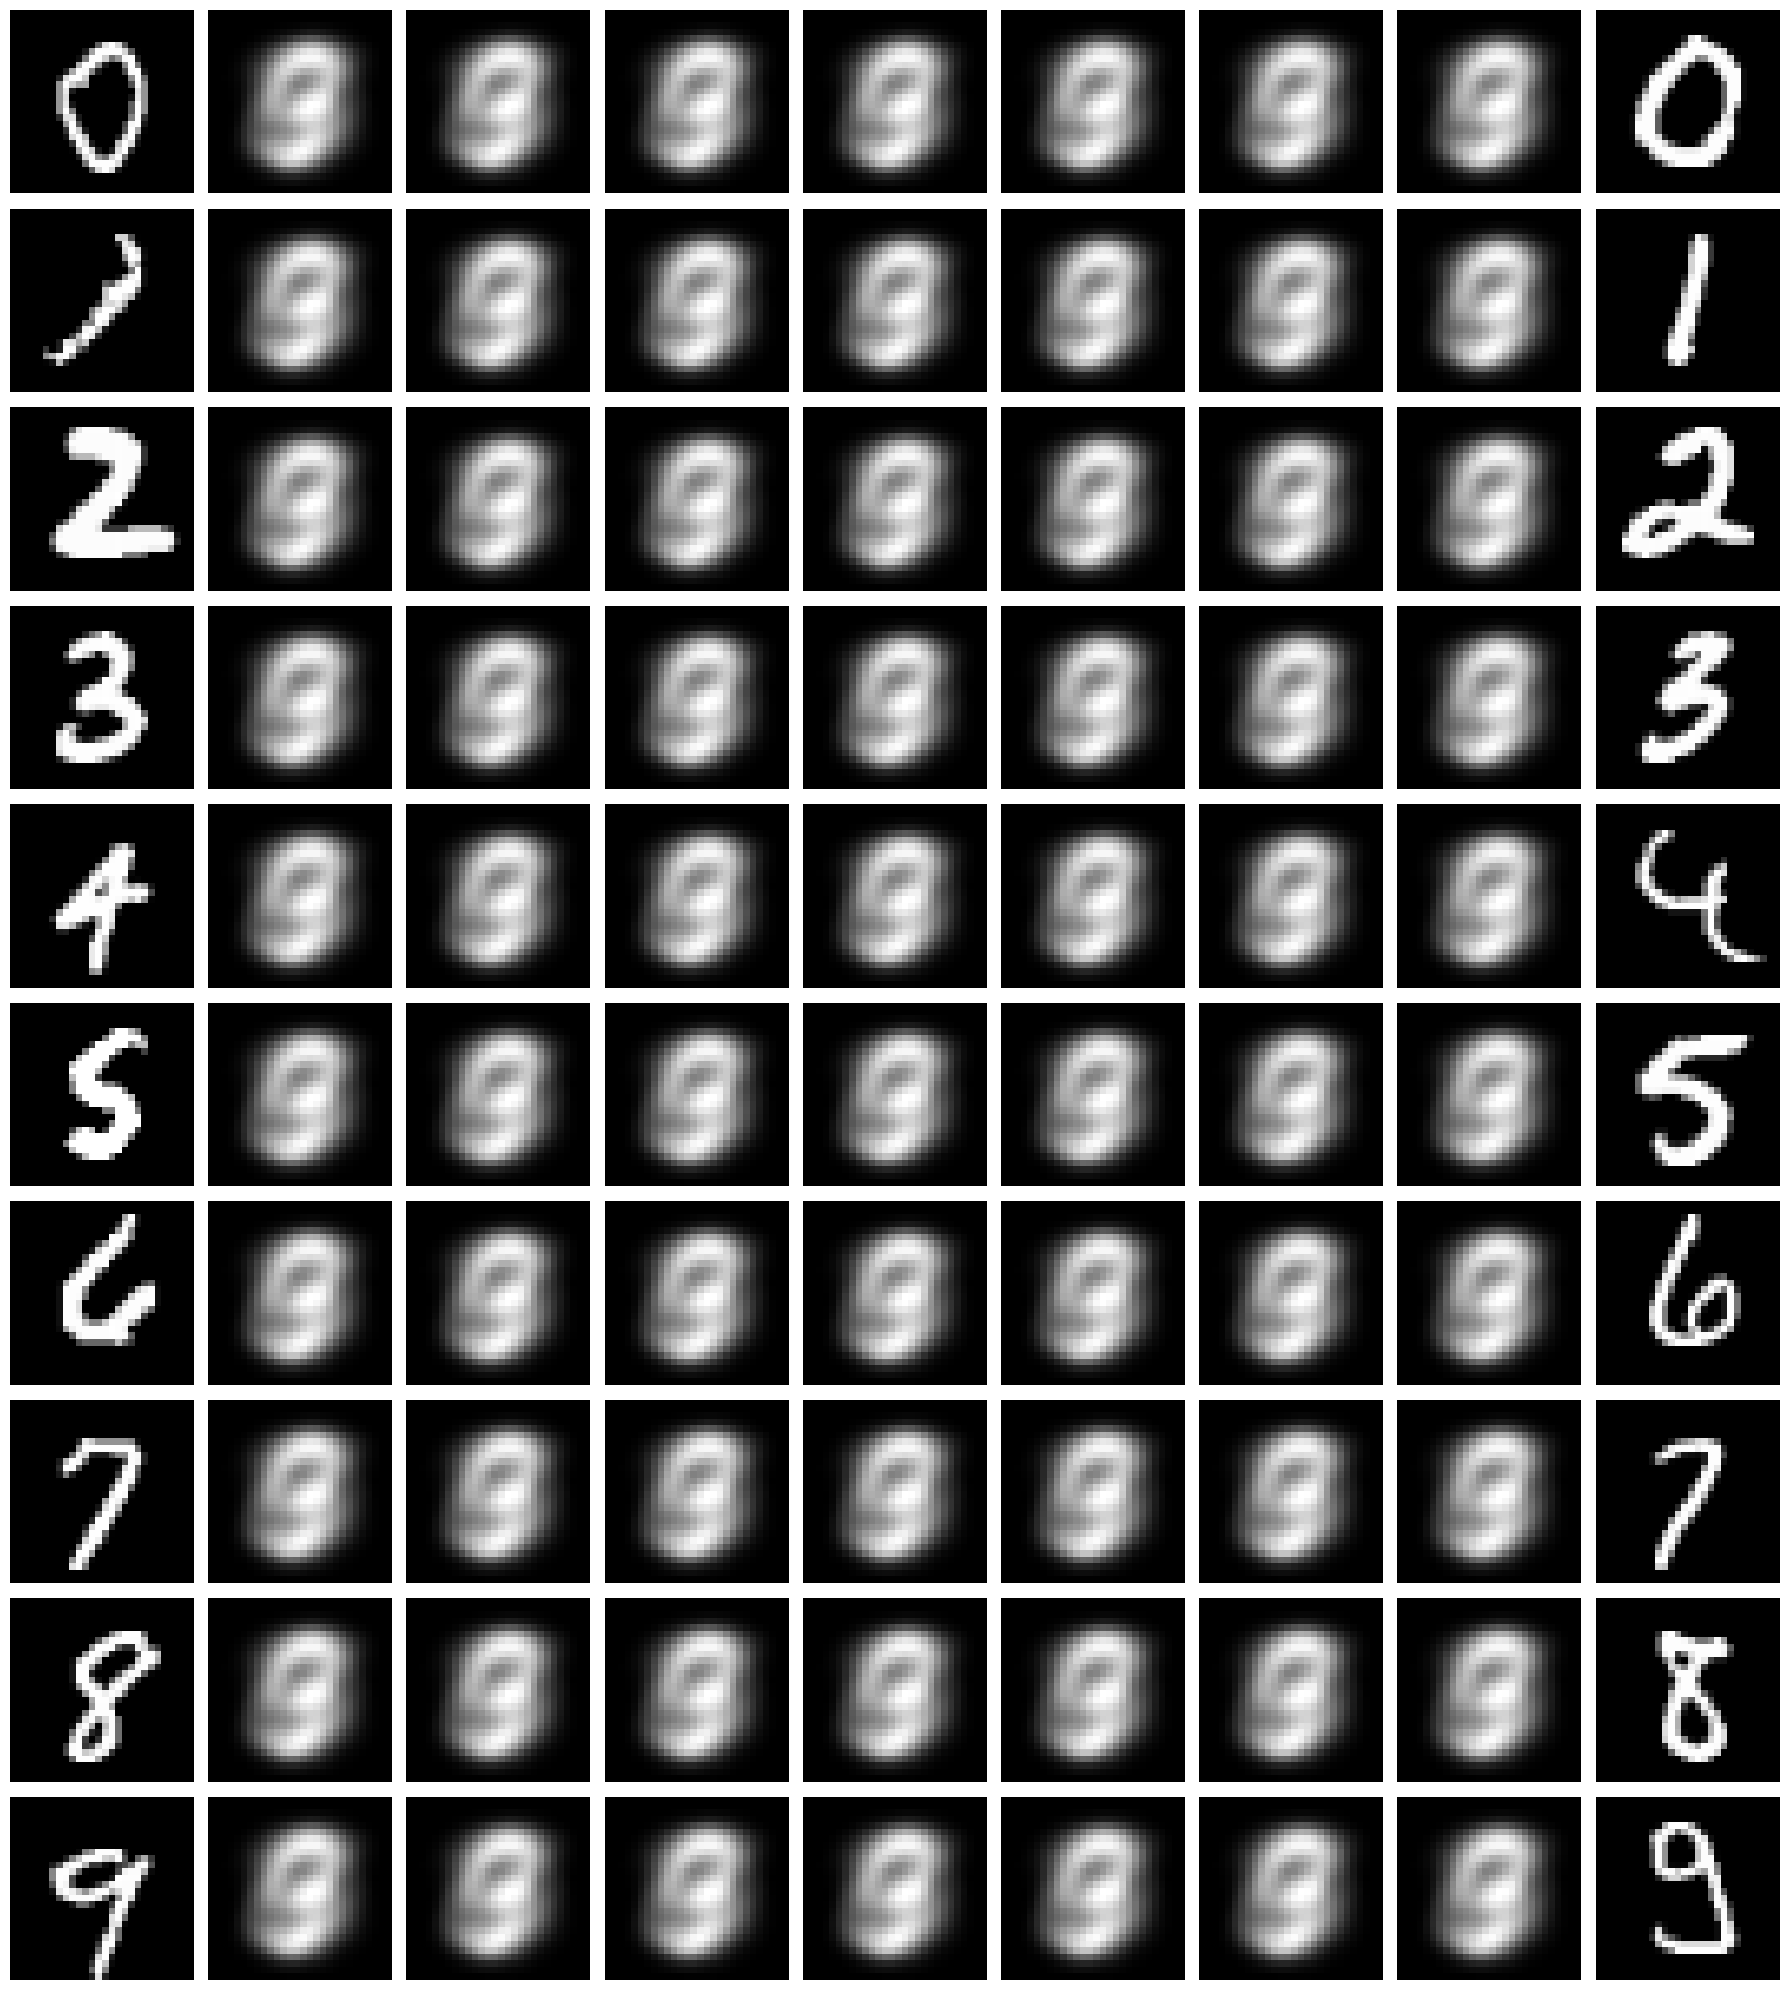

In [24]:
# Generate pairs for interpolation
same_digit_pairs = [(np.random.choice(np.where(y_test == d)[0], 2, replace=False)) for d in range(10)]
diff_digit_pairs = [(np.random.choice(np.where(y_test == d1)[0]), np.random.choice(np.where(y_test == d2)[0]))
                    for d1, d2 in zip(range(10), np.random.permutation(10))]

print("\n\n******* Interpolation for same digits ******\n")
generate_interpolation_figure(same_digit_pairs, same_digit=True)


---
#### **Interpolation for Different Digits**





******* Interpolation for different digits *******



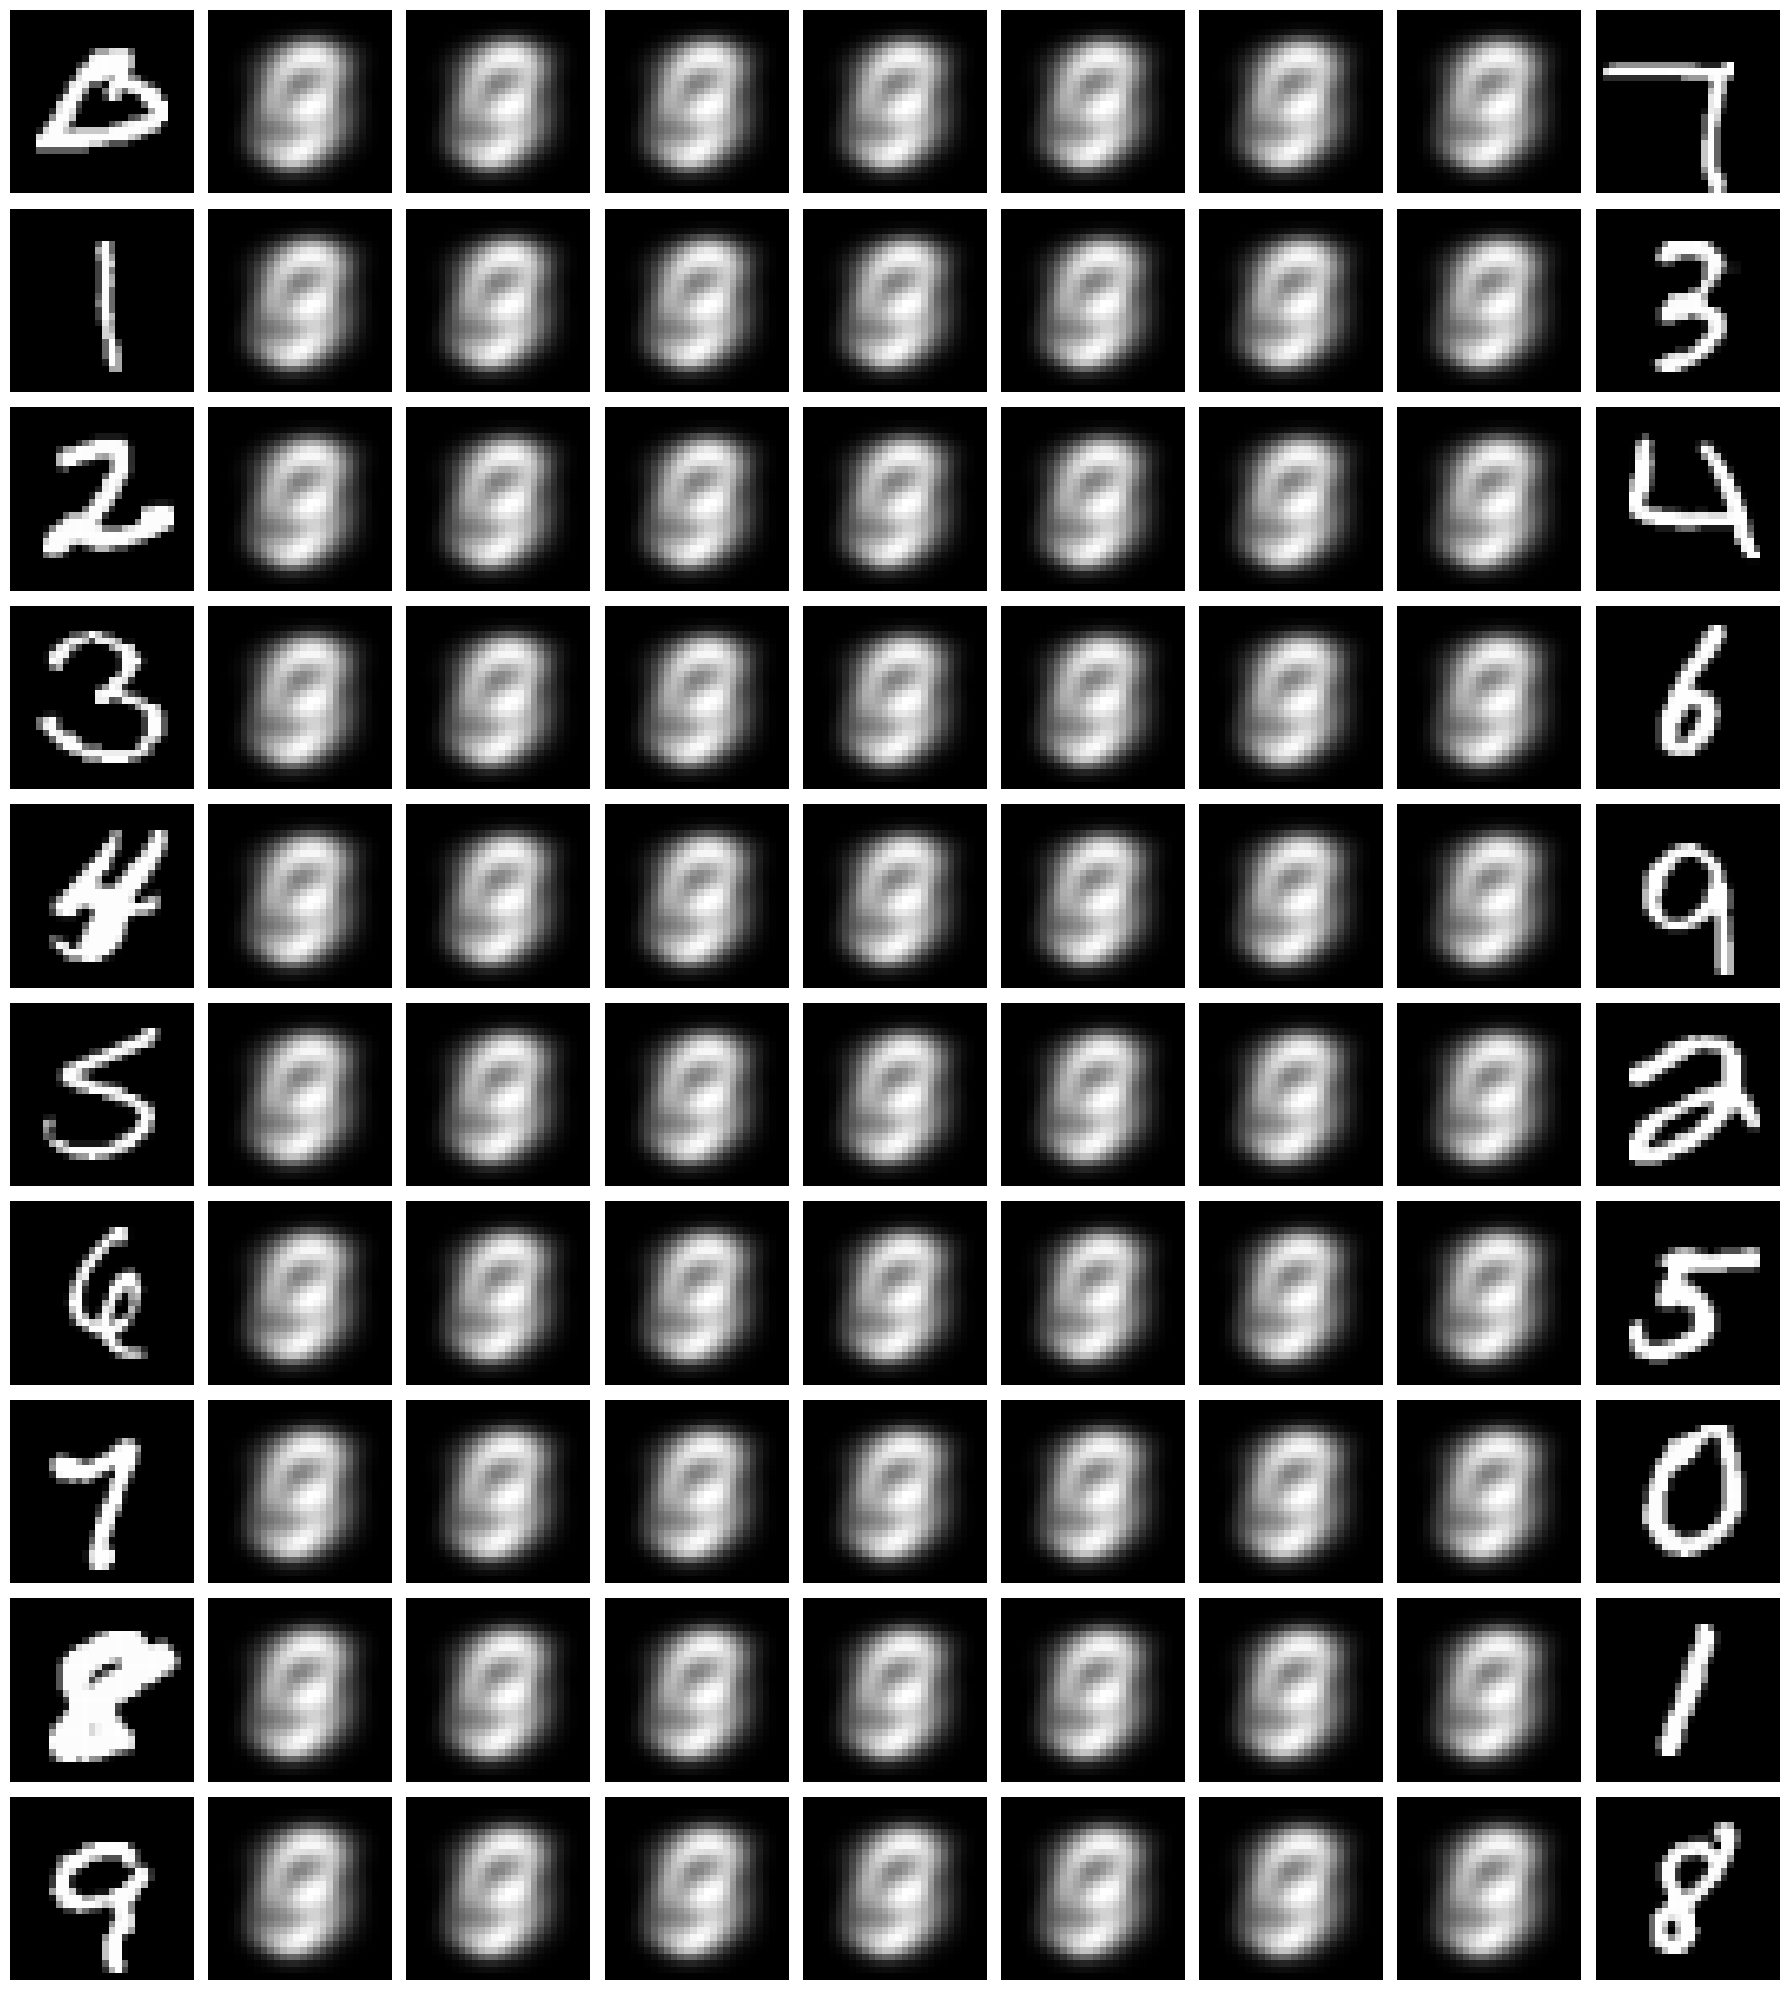

In [25]:
print("\n\n\n******* Interpolation for different digits *******\n")
generate_interpolation_figure(diff_digit_pairs, same_digit=False)

**END**

---